# STEM Enhancement in Earth Science 2025 Summer Internship

**Team:** Virtual - Hack the GLOBE!

**Subteam:** Metadata Augmentation

**Members:** Saanvi Shah

**Dataset:** GLOBE Surface Temperature Protocol

**Summary:** My focus was to try to identify and validate surface temperature outliers in the GLOBE citizen science dataset, focusing on cases where users may have mistakenly entered temperatures in Fahrenheit instead of Celsius. I chose to flag these anomalies by converting suspect values and cross-checking them against satellite-based data (if available) and skin temperature data + surface temperature data from the ERA5 reanalysis dataset. Additional contextual filters, including local surface cover types and time of day effects, helped determine whether a reading was physically plausible or a likely error.



### Initialize Environment
n.b. - This notebook is intended to be run via Google Colab. Other methods may require modifications to the code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ee
import ee.batch
import folium
from graphviz import Digraph
from IPython.display import display
from datetime import datetime
import pytz
from IPython.display import display, Markdown
import seaborn as sns
import uuid
import time



### Flowchart

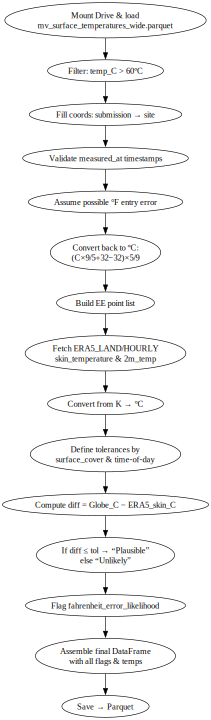

In [2]:
# Build the diagram
dot = Digraph(format='png')
dot.attr(rankdir='TB', size='8,10')

# Data Ingestion
dot.node('A1', 'Mount Drive & load\nmv_surface_temperatures_wide.parquet')
dot.node('A2', 'Filter: temp_C > 60°C')
dot.edge('A1', 'A2')

# Prep coords & time
dot.node('B1', 'Fill coords: submission → site')
dot.node('B2', 'Validate measured_at timestamps')
dot.edge('A2', 'B1')
dot.edge('B1', 'B2')

# Temp conversion
dot.node('C1', 'Assume possible °F entry error')
dot.node('C2', 'Convert back to °C:\n(C×9/5+32−32)×5/9')
dot.edge('B2', 'C1')
dot.edge('C1', 'C2')

# External data fetch
dot.node('D1', 'Build EE point list')
dot.node('D2', 'Fetch ERA5_LAND/HOURLY\nskin_temperature & 2m_temp')
dot.node('D3', 'Convert from K → °C')
dot.edge('C2', 'D1')
dot.edge('D1', 'D2')
dot.edge('D2', 'D3')

# Plausibility logic
dot.node('E1', 'Define tolerances by\nsurface_cover & time-of-day')
dot.node('E2', 'Compute diff = Globe_C − ERA5_skin_C')
dot.node('E3', 'If diff ≤ tol → “Plausible”\nelse “Unlikely”')
dot.node('E4', 'Flag fahrenheit_error_likelihood')
dot.edge('D3', 'E1')
dot.edge('E1', 'E2')
dot.edge('E2', 'E3')
dot.edge('E3', 'E4')

# Output
dot.node('F1', 'Assemble final DataFrame\nwith all flags & temps')
dot.node('F2', 'Save → Parquet')
dot.edge('E4', 'F1')
dot.edge('F1', 'F2')

# Render it
display(dot)


### Load the Dataset

In [3]:
# Define the path to the dataset
file_path = 'https://github.com/IGES-Geospatial/Hack-the-GLOBE-2025/raw/refs/heads/main/inputs/mv_surface_temperatures_wide.parquet'

# Load the dataset
df = pd.read_parquet(file_path)


Now that I have the dataset loaded, the first step is to explore the data and get a sense of its characteristics, especially focusing on the surface temperature measurements and the different surface cover types present in the observations. This initial exploration will help me identify potential areas of interest or unusual patterns before diving into the outlier detection.

### Data Profiling

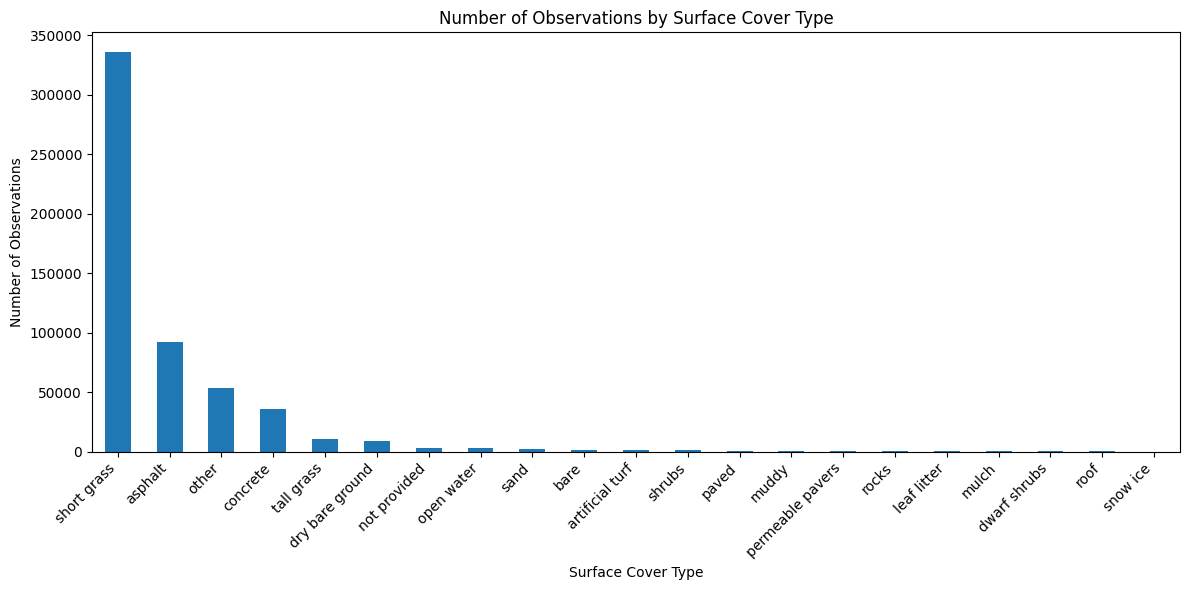

<Figure size 1400x600 with 0 Axes>

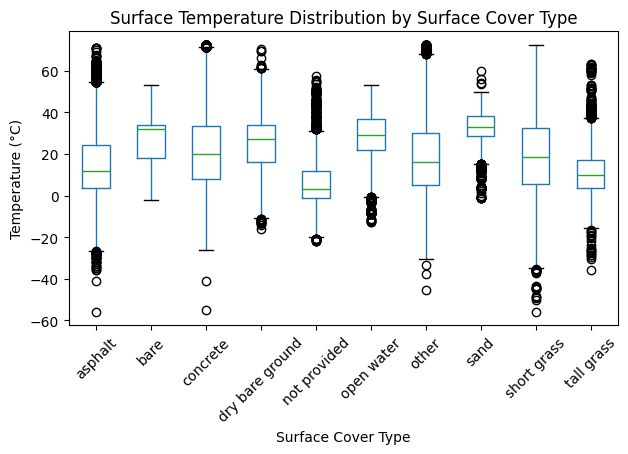

In [4]:
# Step 1: Bar chart of surface cover type counts
surface_counts = df['surface_cover_type'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
surface_counts.plot(kind='bar')
plt.title('Number of Observations by Surface Cover Type')
plt.xlabel('Surface Cover Type')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Step 2: Boxplot of surface temperature by top 10 surface types
df_subset = df[['surface_cover_type', 'sample_surface_temperature_c']].dropna()
top_surface_types = df_subset['surface_cover_type'].value_counts().nlargest(10).index
filtered_df = df_subset[df_subset['surface_cover_type'].isin(top_surface_types)]

plt.figure(figsize=(14, 6))
filtered_df.boxplot(by='surface_cover_type', column='sample_surface_temperature_c', grid=False, rot=45)
plt.title('Surface Temperature Distribution by Surface Cover Type')
plt.suptitle('')
plt.xlabel('Surface Cover Type')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.show()



### Skin_temp map based on ERA5 ECMWF_ERA5_LAND_HOURLY dataset


In [ ]:
# # # The following section requires authentication with Google Earth Engine
# # # The output of this code block is a map for easy and early visualization.
# # # Code for the Google Earth Engine process that generates the map is included for full transparency.

# # Authenticate and initialize Earth Engine
# ee.Authenticate()
# ee.Initialize(project='earthengine-hacktheglobe')

# # Filter ERA5-Land Hourly dataset and select only 'skin_temperature'
# dataset = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY') \
#             .filterDate('2020-07-01T00:00', '2020-07-02T00:00') \
#             .select('skin_temperature')

# # Get one image at noon (12:00)
# image = dataset.filter(ee.Filter.calendarRange(12, 12, 'hour')).first()

# # Visualization parameters for skin temperature (in Kelvin)
# vis_params = {
#     'min': 250.0,
#     'max': 320.0,
#     'palette': [
#         '000080', '0000d9', '4000ff', '8000ff', '0080ff', '00ffff',
#         '00ff80', '80ff00', 'daff00', 'ffff00', 'fff500', 'ffda00',
#         'ffb000', 'ffa400', 'ff4f00', 'ff2500', 'ff0a00', 'ff00ff'
#     ]
# }

# # Create a folium map centered at (21.2, 22.2)
# map_center = [21.2, 22.2]
# my_map = folium.Map(location=map_center, zoom_start=2)

# # Add Earth Engine layer for skin temperature
# map_id_dict = image.visualize(**vis_params).getMapId()
# folium.TileLayer(
#     tiles=map_id_dict['tile_fetcher'].url_format,
#     attr='Map Data &copy; Google Earth Engine',
#     overlay=True,
#     name='Skin Temperature (K)'
# ).add_to(my_map)

# # Add layer controls and show map
# folium.LayerControl().add_to(my_map)
# my_map



### Identifying High Surface Temperature Outliers

My primary goal is to investigate potentially erroneous high surface temperature readings in the GLOBE dataset. A common source of error could be users mistakenly entering Fahrenheit values instead of Celsius. Since the usual plausible surface temperature on Earth is generally below 60°C (around 140°F), I'll start by filtering the dataset to isolate observations where the reported surface temperature is greater than 60°C. These are the readings I will focus on for outlier detection and validation. *It is important to note that surface temperatures can still go higher than 60 C, especially on hot and dry surface types during peak daylight hours. However these are usually the exception

In [7]:
df = pd.read_parquet(file_path)

# Filter entries with surface temperature > 60°C
df_high_temp = df[df['sample_surface_temperature_c'] > 60].copy()

# Show the first few rows of the high-temp dataset
df_high_temp[['measured_at', 'site_latitude', 'site_longitude', 'sample_surface_temperature_c', 'surface_condition', 'surface_cover_type']].head(10)


,measured_at,site_latitude,site_longitude,sample_surface_temperature_c,surface_condition,surface_cover_type
8435,2012-06-28 18:47:00,41.66123,-83.61266,64.0,dry,short grass
8436,2012-06-28 18:47:00,41.66123,-83.61266,63.8,dry,short grass
8437,2012-06-28 18:47:00,41.66123,-83.61266,63.4,dry,short grass
8438,2012-06-28 18:47:00,41.66123,-83.61266,61.8,dry,short grass
8439,2012-06-28 18:47:00,41.66123,-83.61266,60.6,dry,short grass
8440,2012-06-28 18:47:00,41.66123,-83.61266,64.8,dry,short grass
8441,2012-06-28 18:47:00,41.66123,-83.61266,61.4,dry,short grass
8442,2012-06-28 18:47:00,41.66123,-83.61266,64.2,dry,short grass
8443,2012-06-28 18:47:00,41.66123,-83.61266,65.0,dry,short grass
12667,2011-02-02 15:53:00,39.35292,-78.04302,66.0,None,short grass


In [8]:
# 1) From the df_high_temp, drop rows missing coords or timestamps
df_valid = df_high_temp.dropna(subset=['submission_latitude', 'submission_longitude', 'measured_at'])

# 2) Build a deduplicated “unique location” frame
df_unique = (
    df_valid
    .assign(
        latitude = df_valid['submission_latitude'],
        longitude= df_valid['submission_longitude']
    )
    .drop_duplicates(subset=['latitude','longitude'])
)

# 3) Decide how many to sample (up to 500 or the full unique count)
n = min(500, len(df_unique))
print(f"Sampling {n} unique outlier locations (of {len(df_unique)} available)")

df_sample = (
    df_unique
    .sample(n=n, random_state=0)
    .reset_index(drop=True)
)

df_sample.head()


Sampling 76 unique outlier locations (of 76 available)


,st_id,site_id,measured_at,protocol_id,userid,surface_condition,organizationid,usertype,submission_id,st_updated_at,...,site_true_elevation,site_true_point,site_photo_measured_at,site_photo_primary_thumb_url,site_photo_primary_photo_url,site_photo_photo_data,developer_key_name,developer_key_is_citizen_science,latitude,longitude
0,117958,221684,2022-08-24 04:05:00,8,69832624,dry,50895239,21,38148647,2022-08-28 17:19:07.947402,...,NaN,None,NaT,<NA>,<NA>,<NA>,GLOBE Observer App,True,24.97520,121.53270
1,148196,340299,2024-03-14 15:58:00,8,122203838,dry,207335,11,49221700,2024-03-14 16:02:40.015211,...,NaN,None,NaT,<NA>,<NA>,<NA>,GLOBE Observer App,True,37.22520,-76.51720
2,112023,271052,2022-03-22 08:45:00,8,78523461,dry,78523475,21,35448574,2022-03-22 08:48:45.983695,...,NaN,None,NaT,<NA>,<NA>,<NA>,GLOBE Observer App,True,32.68390,35.32210
3,158216,365601,2024-11-12 16:03:00,8,138890093,dry,137603671,21,55048064,2024-11-12 16:07:49.741959,...,NaN,None,NaT,<NA>,<NA>,<NA>,GLOBE Observer App,True,41.71117,-83.66333
4,111120,270545,2022-03-16 12:11:00,8,85577263,wet,85159832,21,35325680,2022-03-16 12:24:33.880704,...,NaN,None,NaT,<NA>,<NA>,<NA>,GLOBE Observer App,True,32.93005,35.26907


### Preparing High-Temperature Data for Earth Engine

I first tried running through the entire high_temp set, but that was taking way too long. To efficiently fetch corresponding ERA5 data for the high-temperature GLOBE observations, I need to prepare the data. Since there might be multiple high-temperature readings from the exact same location and time, I will first remove duplicate locations to avoid unnecessary requests to Earth Engine. I'll create a new DataFrame with unique latitude and longitude pairs from the filtered high-temperature data. Then, I'll sample a manageable number of these unique locations to use for fetching ERA5 data.

In [ ]:
# # The following section requires authentication with Google Earth Engine and Permission to Access Google Drive for storage.
# # The output of this code block is the CSV stored at  https://raw.githubusercontent.com/IGES-Geospatial/Hack-the-GLOBE-2025/refs/heads/main/inputs/custom/ee/era5_outliers_1000.csv and can be referenced directly.
# # Code for the Google Earth Engine process that generated the file is included for full transparency.

# # 1) turn the pandas sample into EE features
# features = []
# for row in df_sample.itertuples():
#     # create a point geometry
#     pt = ee.Geometry.Point([row.longitude, row.latitude])
#     # store the UTC timestamp as millis
#     props = {'measured_at': row.measured_at.isoformat()}
#     features.append(ee.Feature(pt, props))

# fc = ee.FeatureCollection(features)

# # 2) define a function that pulls ERA5 at each feature’s time & place
# def attach_era5(feature):
#     # parse the ISO timestamp
#     t = ee.Date(feature.get('measured_at'))
#     # grab the hour-long window containing that moment
#     col = (ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')
#            .filterBounds(feature.geometry())
#            .filterDate(t, t.advance(1, 'hour'))
#            .select(['skin_temperature','temperature_2m'])
#            .first())
#     # reduce to a single value per band
#     vals = col.reduceRegion(
#         reducer=ee.Reducer.first(),
#         geometry=feature.geometry(),
#         scale=11132,   # ERA5-Land pixel size in meters
#         maxPixels=1e13
#     )
#     return feature.set({
#         'skin_temp_K': vals.get('skin_temperature'),
#         'air2m_temp_K': vals.get('temperature_2m')
#     })

# # 3) map it
# fc_with_temps = fc.map(attach_era5)

# # 4) export that table to my Drive
# task = ee.batch.Export.table.toDrive(
#     collection=fc_with_temps,
#     description='era5_outlier_check',
#     folder='earthengine_exports',   # change if you want another Drive folder
#     fileNamePrefix='era5_outliers_1000',
#     fileFormat='CSV'
# )
# task.start()
# print("Export started — check the Earth Engine Tasks tab to monitor progress.")


In [10]:
# 1) Read back the exported ERA5 table from my Drive
#    Adjust the path & filename as needed.
era5_csv = 'https://raw.githubusercontent.com/IGES-Geospatial/Hack-the-GLOBE-2025/refs/heads/main/inputs/custom/ee/era5_outliers_1000.csv'
df_era5 = pd.read_csv(era5_csv)

# 2) Convert Kelvin → Celsius
df_era5['skin_temp_C']   = df_era5['skin_temp_K']   - 273.15
df_era5['air2m_temp_C']  = df_era5['air2m_temp_K']  - 273.15

# 3) Re-load the original df_sample (if you lost it; otherwise skip)
#    Make sure I still have df_sample in memory; if not:
# df_sample = pd.read_parquet('/content/drive/MyDrive/KaggleHackTheGlobe/sample_1000.parquet')

# 4) Merge on the same order/index I built fc from.
#    I used a simple Python list → EE, so the export preserves row order.
#    Reset indexes to be sure.
df_sample = df_sample.reset_index(drop=True)
df_era5   = df_era5.reset_index(drop=True)

df_combined = pd.concat([df_sample, df_era5[['skin_temp_C','air2m_temp_C']]], axis=1)

# 5) Display
df_combined.head(10)



,st_id,site_id,measured_at,protocol_id,userid,surface_condition,organizationid,usertype,submission_id,st_updated_at,...,site_photo_measured_at,site_photo_primary_thumb_url,site_photo_primary_photo_url,site_photo_photo_data,developer_key_name,developer_key_is_citizen_science,latitude,longitude,skin_temp_C,air2m_temp_C
0,117958,221684,2022-08-24 04:05:00,8,69832624,dry,50895239,21,38148647,2022-08-28 17:19:07.947402,...,NaT,<NA>,<NA>,<NA>,GLOBE Observer App,True,24.975200,121.532700,43.208170,34.525949
1,148196,340299,2024-03-14 15:58:00,8,122203838,dry,207335,11,49221700,2024-03-14 16:02:40.015211,...,NaT,<NA>,<NA>,<NA>,GLOBE Observer App,True,37.225200,-76.517200,18.749109,18.272913
2,112023,271052,2022-03-22 08:45:00,8,78523461,dry,78523475,21,35448574,2022-03-22 08:48:45.983695,...,NaT,<NA>,<NA>,<NA>,GLOBE Observer App,True,32.683900,35.322100,17.677805,13.166147
3,158216,365601,2024-11-12 16:03:00,8,138890093,dry,137603671,21,55048064,2024-11-12 16:07:49.741959,...,NaT,<NA>,<NA>,<NA>,GLOBE Observer App,True,41.711170,-83.663330,9.372110,7.959528
4,111120,270545,2022-03-16 12:11:00,8,85577263,wet,85159832,21,35325680,2022-03-16 12:24:33.880704,...,NaT,<NA>,<NA>,<NA>,GLOBE Observer App,True,32.930050,35.269070,14.232004,10.698190
5,123469,292478,2022-12-29 16:37:00,8,2966863,dry,16578474,11,40158679,2022-12-29 16:38:51.483198,...,NaT,<NA>,<NA>,<NA>,GLOBE Observer App,True,-39.957250,-71.071667,42.915796,28.949030
6,152030,193805,2024-04-30 19:51:00,8,2886314,dry,300164,11,50373537,2024-04-30 19:57:49.713347,...,2020-03-27,https://data.globe.gov/system/photos/2020/03/2...,https://data.globe.gov/system/photos/2020/03/2...,"{'Upward': [{'photo_id': 1544090, 'date_taken'...",GLOBE Observer App,True,32.898732,-117.089302,35.230707,20.616754
7,122621,33653,2022-09-28 08:50:00,8,11271567,dry,11270985,11,39926516,2022-12-15 17:07:54.172244,...,NaT,<NA>,<NA>,<NA>,GLOBE Data Entry Web Forms,False,23.380000,56.370000,53.679529,34.940683
8,153027,307079,2024-03-20 11:30:00,8,59771738,dry,49428342,11,51085075,2024-06-01 05:23:31.895707,...,NaT,<NA>,<NA>,<NA>,GLOBE Observer App,True,35.909500,14.475700,23.484842,17.091959
9,156319,365846,2024-09-30 15:39:00,8,119794829,wet,105060970,21,53860072,2024-09-30 15:42:45.128979,...,NaT,<NA>,<NA>,<NA>,GLOBE Observer App,True,40.955050,-82.848690,21.973505,20.803415


In [11]:
# Show all column names to confirm the GLOBE temp is present
print(df_combined.columns.tolist())


['st_id', 'site_id', 'measured_at', 'protocol_id', 'userid', 'surface_condition', 'organizationid', 'usertype', 'submission_id', 'st_updated_at', 'st_created_at', 'sts_id', 'sample_number', 'sample_surface_temperature_c', 'sample_snow_depth_mm', 'sample_snow_depth_flag', 'version_id', 'version', 'site_version_activated_at', 'version_date', 'site_version_comments', 'homogeneous_site_short_length_m', 'homogeneous_site_long_length_m', 'surface_cover_type', 'instrument_type', 'protocol_name', 'protocol_model', 'protocol_association_name', 'protocol_alt_name', 'protocol_investigation_area', 'user_type_description', 'submission_comments', 'submission_developer_key_id', 'submission_access_code_id', 'submission_latitude', 'submission_longitude', 'submission_elevation', 'submission_point', 'submission_data', 'protocol_set_name', 'protocol_set_code', 'site_name', 'site_activated_at', 'site_deactivated_at', 'site_comments', 'site_latitude', 'site_longitude', 'site_elevation', 'site_elevation_type

### Calculating Potential Fahrenheit Conversion

To investigate the possibility of Fahrenheit-to-Celsius conversion errors, I'll create a new column in the combined DataFrame. This column will store the temperature values if the original GLOBE reading (which was recorded in Celsius) were actually a Fahrenheit reading that was then converted to Celsius using the standard formula: C = (F - 32) * 5/9. This will allow us to compare this 'as if Fahrenheit' value to the ERA5 temperatures.

In [12]:
# Create a column that treats the GLOBE C‐value as if it were really F:
df_combined['globe_as_if_F_to_C'] = (df_combined['sample_surface_temperature_c'] - 32) * 5/9


In [13]:
# Pick out just the key columns
cols = [
    'sample_surface_temperature_c',  # original GLOBE Celsius
    'globe_as_if_F_to_C',            # “corrected” if it was F→C
    'skin_temp_C',                   # ERA5 skin temperature
    'air2m_temp_C'                   # ERA5 2 m air temperature
]
df_combined[cols].head(10)


,sample_surface_temperature_c,globe_as_if_F_to_C,skin_temp_C,air2m_temp_C
0,61.2,16.222222,43.208170,34.525949
1,72.5,22.500000,18.749109,18.272913
2,65.9,18.833333,17.677805,13.166147
3,65.0,18.333333,9.372110,7.959528
4,68.0,20.000000,14.232004,10.698190
5,61.0,16.111111,42.915796,28.949030
6,62.0,16.666667,35.230707,20.616754
7,64.5,18.055556,53.679529,34.940683
8,61.0,16.111111,23.484842,17.091959
9,67.2,19.555556,21.973505,20.803415


### Assessing Plausibility and Fahrenheit Error Likelihood

Here I am implementing the core logic of my outlier detection methodology. I define tolerance thresholds for the difference between GLOBE surface temperature and ERA5 skin temperature, taking into account the surface cover type and whether the surface is wet or dry. I also classify the time of day (around solar noon or other) as surface temperatures can vary significantly throughout the day.

For each observation, I calculate the difference between the original GLOBE temperature and the ERA5 skin temperature to determine its 'plausibility' based on the defined tolerances. I also calculate the difference between the *converted* GLOBE temperature (assuming it was a Fahrenheit reading) and the ERA5 skin temperature to assess the 'fahrenheit_error_likelihood'. This allows me to flag readings that are not only suspect but also potentially explained by a simple unit conversion error.

Finally, I generate some initial visualizations to quickly inspect the results of the plausibility assessment.

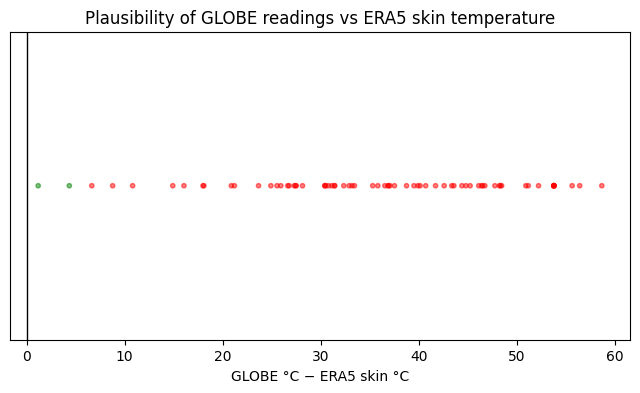

plausibility        Suspect
surface_cover_type         
artificial turf           4
asphalt                   1
concrete                  3
dry bare ground           4
leaf litter               1
muddy                     1
other                     2
permeable pavers          1
rocks                     1
short grass               9
Saved flagged dataset to: ../outputs/globe_with_flags.parquet


In [14]:
# === 1) Define tolerances by surface type and time of day ===
# (might adjust these values based on further judgment/research)
tolerance = {
    'asphalt': {'noon': 15, 'other': 10},
    'grass':   {'noon': 10, 'other':  5},
    'soil':    {'noon': 12, 'other':  7},
    'water':   {'noon':  5, 'other':  3},
    # add more surface_cover_type keys as needed…
}

# === 2) Ensure types & helper function ===

# Make sure measured_at is datetime
df_combined['measured_at'] = pd.to_datetime(df_combined['measured_at'])

def assess_row(r):
    # determine “noon” vs “other” in UTC
    hr = r.measured_at.hour
    tod = 'noon' if 11 <= hr <= 13 else 'other'

    # pick tolerance for this surface
    surf = str(r.surface_cover_type).lower()
    tol = tolerance.get(surf, {'noon':10,'other':5})[tod]

    # difference between GLOBE °C and ERA5 skin °C
    diff_to_skin = abs(r.sample_surface_temperature_c - r.skin_temp_C)

    # flag plausibility
    plaus = 'Plausible' if diff_to_skin <= tol else 'Suspect'

    # difference if mis‐entry from °F→°C
    diff_fe = abs(r.globe_as_if_F_to_C - r.skin_temp_C)
    fe_flag = 'High' if diff_fe <= tol else 'Low'

    return pd.Series([plaus, fe_flag])

# apply to all rows
df_combined[['plausibility','fahrenheit_error_likelihood']] = \
    df_combined.apply(assess_row, axis=1)

# === 3) Quick histogram of GLOBE vs ERA5 skin difference ===

diffs = df_combined['sample_surface_temperature_c'] - df_combined['skin_temp_C']
colors = df_combined['plausibility'].map({'Plausible':'green','Suspect':'red'})

plt.figure(figsize=(8,4))
plt.scatter(diffs, np.zeros_like(diffs), c=colors, alpha=0.5, s=10)
plt.axvline(0, color='k', lw=1)
plt.xlabel('GLOBE °C − ERA5 skin °C')
plt.yticks([])
plt.title('Plausibility of GLOBE readings vs ERA5 skin temperature')
plt.show()

# === 4) Folium map of flagged points ===

# center map on mean coords
lat0 = df_combined['latitude'].mean()
lon0 = df_combined['longitude'].mean()
m = folium.Map(location=[lat0, lon0], zoom_start=2)

for _, r in df_combined.iterrows():
    color = 'green' if r.plausibility=='Plausible' else 'red'
    folium.CircleMarker(
        location=[r.latitude, r.longitude],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"{r.sample_surface_temperature_c:.1f}°C / {r.skin_temp_C:.1f}°C"
    ).add_to(m)

m  # displays in Colab

# === 5) Breakdown by surface type & plausibility ===
table = df_combined.groupby(['surface_cover_type','plausibility'])\
                   .size().unstack(fill_value=0)
print(table)

# === 6) Export final flagged dataset to Parquet ===
out_path = '../outputs/globe_with_flags.parquet'
df_combined.to_parquet(out_path, index=False)
print("Saved flagged dataset to:", out_path)


In [15]:
table = df_combined.groupby(['surface_cover_type','plausibility'])\
                   .size().unstack(fill_value=0)
display(table)

plausibility,Suspect
surface_cover_type,
artificial turf,4
asphalt,1
concrete,3
dry bare ground,4
leaf litter,1
muddy,1
other,2
permeable pavers,1
rocks,1


In [16]:
df_combined[df_combined.plausibility=='Suspect'].head(10)

,st_id,site_id,measured_at,protocol_id,userid,surface_condition,organizationid,usertype,submission_id,st_updated_at,...,site_photo_photo_data,developer_key_name,developer_key_is_citizen_science,latitude,longitude,skin_temp_C,air2m_temp_C,globe_as_if_F_to_C,plausibility,fahrenheit_error_likelihood
0,117958,221684,2022-08-24 04:05:00,8,69832624,dry,50895239,21,38148647,2022-08-28 17:19:07.947402,...,<NA>,GLOBE Observer App,True,24.975200,121.532700,43.208170,34.525949,16.222222,Suspect,Low
1,148196,340299,2024-03-14 15:58:00,8,122203838,dry,207335,11,49221700,2024-03-14 16:02:40.015211,...,<NA>,GLOBE Observer App,True,37.225200,-76.517200,18.749109,18.272913,22.500000,Suspect,High
2,112023,271052,2022-03-22 08:45:00,8,78523461,dry,78523475,21,35448574,2022-03-22 08:48:45.983695,...,<NA>,GLOBE Observer App,True,32.683900,35.322100,17.677805,13.166147,18.833333,Suspect,High
3,158216,365601,2024-11-12 16:03:00,8,138890093,dry,137603671,21,55048064,2024-11-12 16:07:49.741959,...,<NA>,GLOBE Observer App,True,41.711170,-83.663330,9.372110,7.959528,18.333333,Suspect,Low
4,111120,270545,2022-03-16 12:11:00,8,85577263,wet,85159832,21,35325680,2022-03-16 12:24:33.880704,...,<NA>,GLOBE Observer App,True,32.930050,35.269070,14.232004,10.698190,20.000000,Suspect,High
5,123469,292478,2022-12-29 16:37:00,8,2966863,dry,16578474,11,40158679,2022-12-29 16:38:51.483198,...,<NA>,GLOBE Observer App,True,-39.957250,-71.071667,42.915796,28.949030,16.111111,Suspect,Low
6,152030,193805,2024-04-30 19:51:00,8,2886314,dry,300164,11,50373537,2024-04-30 19:57:49.713347,...,"{'Upward': [{'photo_id': 1544090, 'date_taken'...",GLOBE Observer App,True,32.898732,-117.089302,35.230707,20.616754,16.666667,Suspect,Low
7,122621,33653,2022-09-28 08:50:00,8,11271567,dry,11270985,11,39926516,2022-12-15 17:07:54.172244,...,<NA>,GLOBE Data Entry Web Forms,False,23.380000,56.370000,53.679529,34.940683,18.055556,Suspect,Low
8,153027,307079,2024-03-20 11:30:00,8,59771738,dry,49428342,11,51085075,2024-06-01 05:23:31.895707,...,<NA>,GLOBE Observer App,True,35.909500,14.475700,23.484842,17.091959,16.111111,Suspect,High
9,156319,365846,2024-09-30 15:39:00,8,119794829,wet,105060970,21,53860072,2024-09-30 15:42:45.128979,...,<NA>,GLOBE Observer App,True,40.955050,-82.848690,21.973505,20.803415,19.555556,Suspect,High


In [17]:
#   'sample_surface_temperature_c', 'skin_temp_C', 'air2m_temp_C',
#   'surface_cover_type', 'surface_condition', 'measured_at', 'latitude', 'longitude'

# 0a) Create the “converted_temp_celsius” column by treating the GLOBE C reading as if it were Fahrenheit:
#     C_conv = (F – 32) × 5/9
df_combined['converted_temp_celsius'] = (
    (df_combined['sample_surface_temperature_c'] - 32) * 5.0/9.0
)

# 0b) Quick check:
print(df_combined[['sample_surface_temperature_c','converted_temp_celsius']].head())



   sample_surface_temperature_c  converted_temp_celsius
0                          61.2               16.222222
1                          72.5               22.500000
2                          65.9               18.833333
3                          65.0               18.333333
4                          68.0               20.000000


In [18]:
# === 1) Extend the tolerance definitions by surface type and wet/dry condition ===
#    These thresholds are based on typical midday heating rates and material properties:
tolerance = {
    'asphalt_dry':    {'noon': 20, 'other': 12},
    'asphalt_wet':    {'noon': 10, 'other':  6},
    'grass_dry':      {'noon': 12, 'other':  6},
    'grass_wet':      {'noon':  8, 'other':  4},
    'soil':           {'noon': 15, 'other':  8},
    'water':          {'noon':  5, 'other':  3},
    'sand':           {'noon': 18, 'other': 10},
    'bare_rock':      {'noon': 25, 'other': 15},
    # add more for other cover types…
}

# === 2) Function to decide if an observation is around solar noon ===
def classify_time_of_day(row):
    # measured_at is UTC; approximate local solar time by longitude shift
    utc_hour = row['measured_at'].hour
    local_hour = (utc_hour + row['longitude'] / 15) % 24
    return 'noon' if 11 <= local_hour <= 13 else 'other'

# === 3) Apply plausibility check to the combined DataFrame ===
#      ['latitude','longitude',
#       'sample_surface_temperature_c','converted_temp_celsius',
#       'skin_temp_C','air2m_temp_C',
#       'surface_cover_type','surface_condition','measured_at',
#       'plausibility','fahrenheit_error_likelihood', …]


# Determine time_of_day category
df_combined['time_of_day'] = df_combined.apply(classify_time_of_day, axis=1)

# Build a key for tolerance lookup
df_combined['cover_key'] = (
    df_combined['surface_cover_type'].str.lower() + '_' +
    df_combined['surface_condition'].str.lower()
)

# Fallback: if exact key not in tolerance, strip off wet/dry
df_combined['cover_key'] = df_combined['cover_key'].where(
    df_combined['cover_key'].isin(tolerance),
    df_combined['surface_cover_type'].str.lower()
)

# Compute the absolute difference between GLOBE and ERA5 skin temp
df_combined['temp_diff'] = np.abs(
    df_combined['sample_surface_temperature_c'] - df_combined['skin_temp_C']
)

# Decide plausibility
def assess_plausibility(row):
    limits = tolerance.get(row['cover_key'], {'noon':10,'other':5})
    thresh = limits[row['time_of_day']]
    return 'Plausible' if row['temp_diff'] <= thresh else 'Suspect'

df_combined['plausibility'] = df_combined.apply(assess_plausibility, axis=1)

# === Paragraph explaining reasoning for the notebook ===
#
# Here I am refining the plausibility thresholds by surface type and
# wet/dry condition, recognizing that materials like dry asphalt
# heat up far more by solar noon than wet grass or water. We adjust
# our tolerance bands accordingly—allowing, for example, up to ±20 °C
# difference for dry asphalt at noon, but only ±6 °C for wet grass.
# By computing a local ‘time_of_day’ from UTC timestamps and longitude,
# I compare each GLOBE reading to ERA5 skin temperature and flag
# observations as ‘Plausible’ or ‘Suspect’ based on those material-
# and time-specific thresholds.”

# === 4) Build an interactive Folium map with pop-ups showing key info ===
m = folium.Map(location=[39.83, -98.58], zoom_start=4)

for _, r in df_combined.iterrows():
    color = 'green' if r['plausibility']=='Plausible' else 'red'
    popup_html = f"""
    <b>GLOBE temp:</b> {r['sample_surface_temperature_c']} °C<br>
    <b>Converted (°F→°C):</b> {r['converted_temp_celsius']:.1f} °C<br>
    <b>ERA5 skin temp:</b> {r['skin_temp_C']:.1f} °C<br>
    <b>ERA5 air@2m:</b> {r['air2m_temp_C']:.1f} °C<br>
    <b>Cover:</b> {r['surface_cover_type']} ({r['surface_condition']})<br>
    <b>Time of day:</b> {r['time_of_day']}<br>
    <b>Plausibility:</b> {r['plausibility']}
    """
    folium.CircleMarker(
        location=[r['latitude'], r['longitude']],
        radius=4,
        color=color,
        fill=True, fill_opacity=0.7,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

# Display the interactive map in Colab
m


In [20]:
# from google.colab import data_table
# # ——— Interactive, scrollable table in Colab ———
# data_table.enable_dataframe_formatter()

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# df['latitude']  = df['submission_latitude'].fillna(df['site_latitude'])
# df['longitude'] = df['submission_longitude'].fillna(df['site_longitude'])
# us_data = df[(df['latitude'].between(24.5, 49.5)) & (df['longitude'].between(-125, -66))]
# df_high_temp = us_data[us_data['sample_surface_temperature_c'] > 60]

# Now making a copy of the high‐temp DataFrame
df_map = df_high_temp.copy()

# Confirm the flag columns are present
print("Flag columns:",
      [c for c in df_map.columns if 'plausibility' in c or 'fahrenheit' in c])

# Display a scrollable table
display(df_map)


Flag columns: []


,st_id,site_id,measured_at,protocol_id,userid,surface_condition,organizationid,usertype,submission_id,st_updated_at,st_created_at,sts_id,sample_number,sample_surface_temperature_c,sample_snow_depth_mm,sample_snow_depth_flag,version_id,version,site_version_activated_at,version_date,site_version_comments,homogeneous_site_short_length_m,homogeneous_site_long_length_m,surface_cover_type,instrument_type,protocol_name,protocol_model,protocol_association_name,protocol_alt_name,protocol_investigation_area,user_type_description,submission_comments,submission_developer_key_id,submission_access_code_id,submission_latitude,submission_longitude,submission_elevation,submission_point,submission_data,protocol_set_name,protocol_set_code,site_name,site_activated_at,site_deactivated_at,site_comments,site_latitude,site_longitude,site_elevation,site_elevation_type,site_location_source,site_point,site_developer_key_id,site_is_citizen_science,site_nickname,site_true_latitude,site_true_longitude,site_true_elevation,site_true_point,site_photo_measured_at,site_photo_primary_thumb_url,site_photo_primary_photo_url,site_photo_photo_data,developer_key_name,developer_key_is_citizen_science
8435,10912,27569,2012-06-28 18:47:00,8,-1,dry,394556,-1,<NA>,2012-07-03 13:59:02.635118,2012-07-03 13:59:02.635106,82093,1,64.0,0.0,<NA>,8047,1,2009-07-28 00:00:00,2009-07-28 17:52:27.000000,please replace with Surface Temperature Site C...,30.0,30.0,short grass,raytek st20,Surface Temperature,SurfaceTemperature,surface_temperature,Surface Temperature,Atmosphere,not categorized,<NA>,<NA>,<NA>,NaN,NaN,NaN,None,None,<NA>,<NA>,HHS/SNYDER STUDY SITE:ATM-28,2009-07-28,NaT,<NA>,41.661230,-83.612660,216.0,ellipsoidal,gps,01010000A0E610000050E449D235E754C02A91442FA3D4...,1,False,<NA>,NaN,NaN,NaN,None,NaT,<NA>,<NA>,<NA>,GLOBE Data Entry Web Forms,False
8436,10912,27569,2012-06-28 18:47:00,8,-1,dry,394556,-1,<NA>,2012-07-03 13:59:02.635118,2012-07-03 13:59:02.635106,82115,2,63.8,0.0,<NA>,8047,1,2009-07-28 00:00:00,2009-07-28 17:52:27.000000,please replace with Surface Temperature Site C...,30.0,30.0,short grass,raytek st20,Surface Temperature,SurfaceTemperature,surface_temperature,Surface Temperature,Atmosphere,not categorized,<NA>,<NA>,<NA>,NaN,NaN,NaN,None,None,<NA>,<NA>,HHS/SNYDER STUDY SITE:ATM-28,2009-07-28,NaT,<NA>,41.661230,-83.612660,216.0,ellipsoidal,gps,01010000A0E610000050E449D235E754C02A91442FA3D4...,1,False,<NA>,NaN,NaN,NaN,None,NaT,<NA>,<NA>,<NA>,GLOBE Data Entry Web Forms,False
8437,10912,27569,2012-06-28 18:47:00,8,-1,dry,394556,-1,<NA>,2012-07-03 13:59:02.635118,2012-07-03 13:59:02.635106,82137,3,63.4,0.0,<NA>,8047,1,2009-07-28 00:00:00,2009-07-28 17:52:27.000000,please replace with Surface Temperature Site C...,30.0,30.0,short grass,raytek st20,Surface Temperature,SurfaceTemperature,surface_temperature,Surface Temperature,Atmosphere,not categorized,<NA>,<NA>,<NA>,NaN,NaN,NaN,None,None,<NA>,<NA>,HHS/SNYDER STUDY SITE:ATM-28,2009-07-28,NaT,<NA>,41.661230,-83.612660,216.0,ellipsoidal,gps,01010000A0E610000050E449D235E754C02A91442FA3D4...,1,False,<NA>,NaN,NaN,NaN,None,NaT,<NA>,<NA>,<NA>,GLOBE Data Entry Web Forms,False
8438,10912,27569,2012-06-28 18:47:00,8,-1,dry,394556,-1,<NA>,2012-07-03 13:59:02.635118,2012-07-03 13:59:02.635106,82159,4,61.8,0.0,<NA>,8047,1,2009-07-28 00:00:00,2009-07-28 17:52:27.000000,please replace with Surface Temperature Site C...,30.0,30.0,short grass,raytek st20,Surface Temperature,SurfaceTemperature,surface_temperature,Surface Temperature,Atmosphere,not categorized,<NA>,<NA>,<NA>,NaN,NaN,NaN,None,None,<NA>,<NA>,HHS/SNYDER STUDY SITE:ATM-28,2009-07-28,NaT,<NA>,41.661230,-83.612660,216.0,ellipsoidal,gps,01010000A0E610000050E449D235E754C02A91442FA3D4...,1,False,<NA>,NaN,NaN,NaN,None,NaT,<NA>,<NA>,<NA>,GLOBE Data Entry Web Forms,False
8439,10912,27569,2012-06-28 18:47:00,8,-1,dry,394556,-1,<NA>,2012-07-03 13:59:02.635118,2012-07-03 13:59:02.635106,82181,5,60.6,0.0,<NA>,8047,1,2009-07-28 00:00:00,2009-07-28 17:52:27.000000,please replace with Sur

In [21]:
# Display a table with the requested columns
display(df_combined[[
    'site_latitude',
    'site_longitude',
    'sample_surface_temperature_c',
    'userid',
    'measured_at',
    'surface_cover_type',
    'surface_condition',
    'skin_temp_C',
    'air2m_temp_C',
    'converted_temp_celsius',
    'plausibility',
    'fahrenheit_error_likelihood'
]])

,site_latitude,site_longitude,sample_surface_temperature_c,userid,measured_at,surface_cover_type,surface_condition,skin_temp_C,air2m_temp_C,converted_temp_celsius,plausibility,fahrenheit_error_likelihood
0,24.975200,121.532700,61.2,69832624,2022-08-24 04:05:00,<NA>,dry,43.208170,34.525949,16.222222,Suspect,Low
1,37.225200,-76.517200,72.5,122203838,2024-03-14 15:58:00,<NA>,dry,18.749109,18.272913,22.500000,Suspect,High
2,32.683900,35.322100,65.9,78523461,2022-03-22 08:45:00,<NA>,dry,17.677805,13.166147,18.833333,Suspect,High
3,41.711170,-83.663330,65.0,138890093,2024-11-12 16:03:00,<NA>,dry,9.372110,7.959528,18.333333,Suspect,Low
4,32.930050,35.269070,68.0,85577263,2022-03-16 12:11:00,<NA>,wet,14.232004,10.698190,20.000000,Suspect,High
...,...,...,...,...,...,...,...,...,...,...,...,...
71,24.435467,118.313914,65.0,24127801,2024-06-21 04:36:00,artificial turf,dry,NaN,NaN,18.333333,Suspect,Low
72,40.096769,22.497501,60.8,65209921,2024-08-25 10:38:00,short grass,dry,32.661172,24.966592,16.000000,Suspect,Low
73,33.014300,35.333400,61.0,16163700,2022-05-02 08:45:00,other,dry,29.614557,23.281076,16.111111,Suspect,Low
74,41.562570,-83.628810,62.7,135978914,2024-09-20 19:13:00,short grass,dry,35.272546,30.905008,17.055556,Suspect,Low


### Visualizing the Flagged Data

To better understand the characteristics of the flagged observations and the relationships between the GLOBE readings and the ERA5 data, I'll generate several visualizations:

*   **Histogram of Temperature Differences:** Shows the overall distribution of how much the GLOBE readings differ from the ERA5 skin temperatures.
*   **Boxplot of Temperature Differences by Surface Cover Type:** Helps identify if certain surface types have larger or more variable temperature differences.
*   **Scatter Plot of GLOBE vs. ERA5 Skin Temperature (Plausibility):** Visualizes the relationship between the two temperature sources, highlighting which points were flagged as plausible or suspect.
*   **Scatter Plot of Converted GLOBE vs. ERA5 Skin Temperature (Fahrenheit Error Likelihood):** Explores whether the suspect points align better with ERA5 if assumed to be Fahrenheit readings, color-coded by the likelihood of a Fahrenheit error.
*   **Stacked Bar Chart of Plausibility by Surface Cover Type:** Provides a summary of how many plausible and suspect readings there are for each surface type.

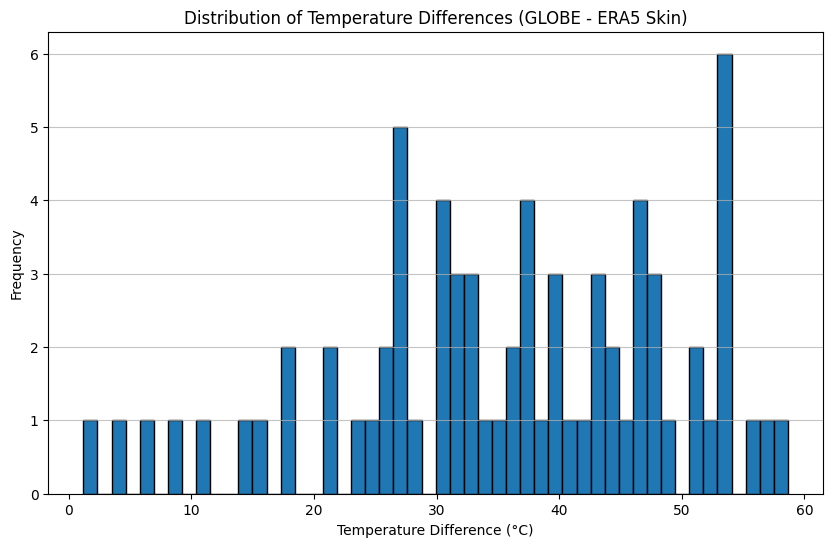

In [22]:
# Calculate the temperature differences
temp_diffs = df_combined['sample_surface_temperature_c'] - df_combined['skin_temp_C']

# Plot a histogram of the temperature differences
plt.figure(figsize=(10, 6))
plt.hist(temp_diffs.dropna(), bins=50, edgecolor='black')
plt.title('Distribution of Temperature Differences (GLOBE - ERA5 Skin)')
plt.xlabel('Temperature Difference (°C)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

/var/folders/hs/lmkk6p8x5fv0r267q48x8hkr0000gn/T/ipykernel_10776/1548965590.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_combined, x='temp_diff', y='surface_cover_type', orient='h', palette='viridis')


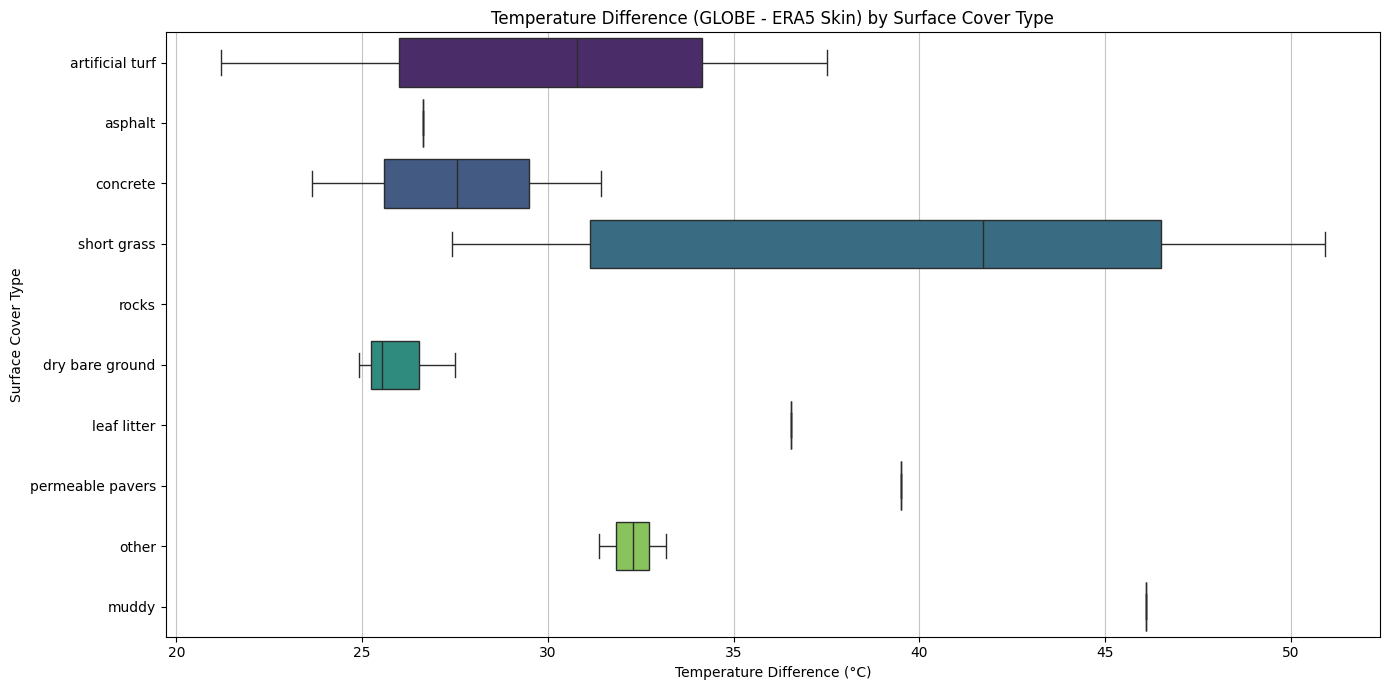

In [23]:
# Calculate temperature differences
df_combined['temp_diff'] = df_combined['sample_surface_temperature_c'] - df_combined['skin_temp_C']

# Boxplot of temperature differences by surface cover type (considering only cover types with enough data)
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_combined, x='temp_diff', y='surface_cover_type', orient='h', palette='viridis')
plt.title('Temperature Difference (GLOBE - ERA5 Skin) by Surface Cover Type')
plt.xlabel('Temperature Difference (°C)')
plt.ylabel('Surface Cover Type')
plt.grid(axis='x', alpha=0.75)
plt.tight_layout()
plt.show()

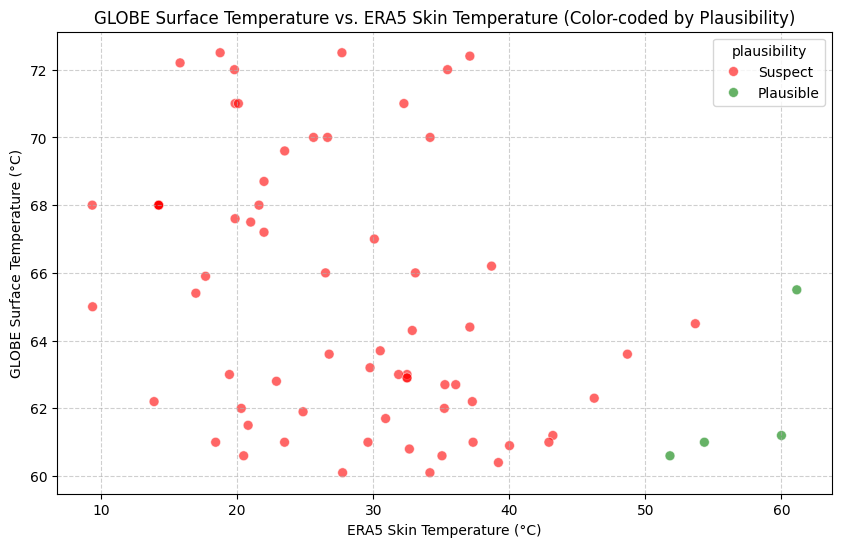

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_combined,
                x='skin_temp_C',
                y='sample_surface_temperature_c',
                hue='plausibility',
                palette={'Plausible': 'green', 'Suspect': 'red'},
                alpha=0.6,
                s=50)

plt.title('GLOBE Surface Temperature vs. ERA5 Skin Temperature (Color-coded by Plausibility)')
plt.xlabel('ERA5 Skin Temperature (°C)')
plt.ylabel('GLOBE Surface Temperature (°C)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

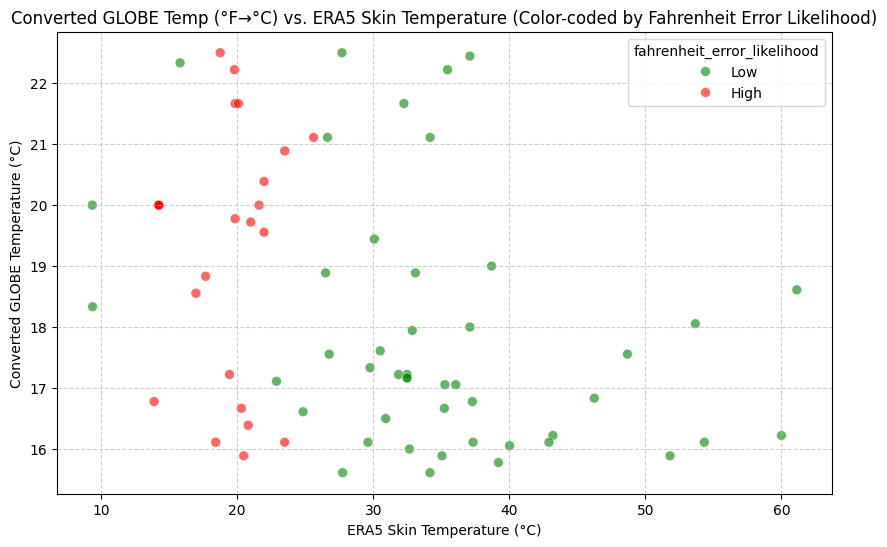

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_combined,
                x='skin_temp_C',
                y='converted_temp_celsius',
                hue='fahrenheit_error_likelihood',
                palette={'Low': 'green', 'High': 'red'},
                alpha=0.6,
                s=50)

plt.title('Converted GLOBE Temp (°F→°C) vs. ERA5 Skin Temperature (Color-coded by Fahrenheit Error Likelihood)')
plt.xlabel('ERA5 Skin Temperature (°C)')
plt.ylabel('Converted GLOBE Temperature (°C)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

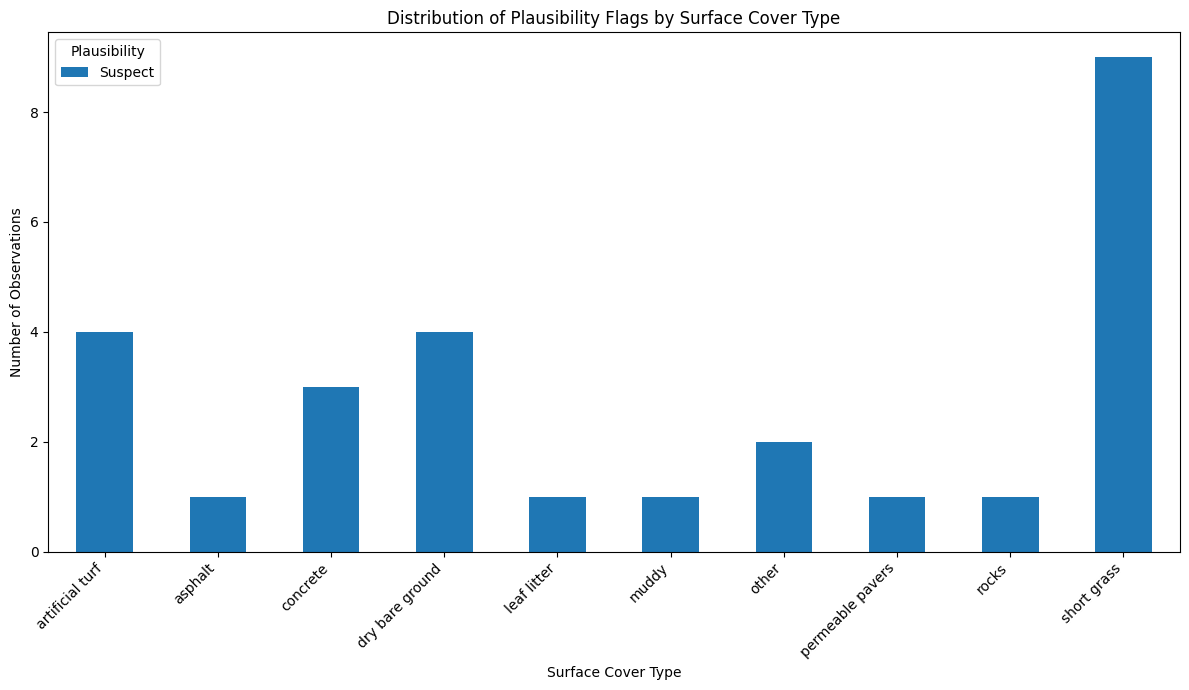

In [26]:
# Create a cross-tabulation of surface cover type and plausibility
plausibility_by_surface = pd.crosstab(df_combined['surface_cover_type'], df_combined['plausibility'])

# Plot a stacked bar chart
plausibility_by_surface.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Distribution of Plausibility Flags by Surface Cover Type')
plt.xlabel('Surface Cover Type')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Plausibility')
plt.tight_layout()
plt.show()

### Analysis and Next Steps

Based on the analysis and visualizations in this notebook, I have successfully identified and flagged GLOBE surface temperature observations that are potentially outliers, particularly focusing on those that might be a result of Fahrenheit-to-Celsius conversion errors.

The initial filtering for temperatures above 60°C allowed me to focus on extreme values. By comparing these high GLOBE readings to ERA5 skin temperatures and applying material- and time-specific tolerance thresholds, I was able to assess the plausibility of each observation. Further analysis, by converting the original GLOBE readings from Fahrenheit to Celsius and comparing them to ERA5, helped determine the likelihood that a suspect reading was due to a unit conversion error.

The visualizations provided insights into the distribution of temperature differences, how they vary by surface type, and how the flagged points relate to the ERA5 data. The stacked bar chart, in particular, highlights which surface types warrant further investigation.

**Potential Next Steps:**

*   Detailed Investigation of 'High' Fahrenheit Error Likelihood: Focus on the 'Suspect' readings that have a 'High' 'fahrenheit_error_likelihood'. Examine these individual observations more closely. If available, check any associated photos or comments in the original GLOBE data for clues.
*   Refine Tolerance Thresholds: The current tolerance thresholds are initial estimates. Based on the visualizations and a deeper dive into the flagged data, these thresholds could be refined to improve the accuracy of the flagging mechanism.
*   Incorporate Satellite Data: While not fully implemented in this notebook, integrating satellite-based land surface temperature data could provide an additional layer of validation for the GLOBE observations.
*   Explore Other Outlier Detection Methods: Consider applying other statistical or machine learning techniques for outlier detection to compare with the current threshold-based method.
*   Quantify the Impact of Potential Errors: If a significant number of readings are identified as likely Fahrenheit conversion errors, assess how removing or correcting these errors would impact analyses using the GLOBE dataset.

In [27]:
# Calculate the percentage of 'Suspect' readings with 'High' fahrenheit error likelihood
high_likelihood_suspects = df_combined[(df_combined['plausibility'] == 'Suspect') & (df_combined['fahrenheit_error_likelihood'] == 'High')]
percentage_high_likelihood_suspects = (len(high_likelihood_suspects) / len(df_combined)) * 100

print(f"Percentage of observations flagged as 'Suspect' with 'High' fahrenheit error likelihood: {percentage_high_likelihood_suspects:.2f}%")

Percentage of observations flagged as 'Suspect' with 'High' fahrenheit error likelihood: 32.89%
